In [1]:
import os
import subprocess
"""
check that the java version is <=17, as spark otherwise raises issues with newer versions of java
"""
java_home = subprocess.check_output(["/usr/libexec/java_home", "-v", "17"]).strip().decode('utf-8')

# Set JAVA_HOME and PATH
os.environ["JAVA_HOME"] = java_home
os.environ["PATH"] = os.path.join(java_home, "bin") + ":" + os.environ["PATH"]
os.environ["PYSPARK_SUBMIT_ARGS"] = "--master local pyspark-shell"

# Verify JAVA_HOME and Java version
print("JAVA_HOME:", os.environ['JAVA_HOME'])
!java -version

JAVA_HOME: /opt/homebrew/Cellar/openjdk@17/17.0.13/libexec/openjdk.jdk/Contents/Home
openjdk version "17.0.13" 2024-10-15
OpenJDK Runtime Environment Homebrew (build 17.0.13+0)
OpenJDK 64-Bit Server VM Homebrew (build 17.0.13+0, mixed mode, sharing)


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder \
    .appName("CBRFSS") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "4") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

We split the data into into train and test set with a ratio of 80/20. 
The following method uses linear regression to create a linear regression model that predicts whether a person has diabetes or not based on the features. One-hot encoding was used for the features "EMPLOY1", "ALCDAY4", "FALL12MN" as these features are nominal. Afterwards, cross-validation was conducted to discover the best regularization and elastic net parameters. After training the model, we made predictions by setting a threshold of 0.5 for binary classification. 
Afterwards, we documented the accuracy and weighted precision as well as the number of false positives and false negatives as well as the true positives and true negatives.

In [4]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

def train(train_df, test_df, threshold=0.5):

    categorical_features = ["EMPLOY1", "ALCDAY4", "FALL12MN"]
    encoder = OneHotEncoder(
        inputCols=categorical_features,
        outputCols=[feature + "_ohe" for feature in categorical_features],
    )

    # Fit and transform the encoder on the training data
    train_df = encoder.fit(train_df).transform(train_df)

    # Transform the test data using the same encoder
    test_df = encoder.fit(test_df).transform(test_df)

    feature_columns = train_df.columns
    feature_columns.remove("y")

    one_hot_columns = [feature + "_ohe" for feature in categorical_features]
    feature_columns += one_hot_columns

    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    train_data = assembler.transform(train_df)

    lr = LinearRegression(featuresCol="features", labelCol="y")

    paramGrid = (
        ParamGridBuilder()
        .addGrid(lr.regParam, [0.1, 0.01, 0.001])
        .addGrid(lr.elasticNetParam, [0.0,0.001,0.01,0.1, 0.5])
        .build()
    )

    crossval = CrossValidator(
        estimator=lr,
        estimatorParamMaps=paramGrid,
        evaluator=RegressionEvaluator(labelCol="y", metricName="rmse"),
        numFolds=5,
    )  

    cv_model = crossval.fit(train_data)

    # Step 4: Evaluate on Test Set
    test_data = assembler.transform(test_df)
    test_predictions = cv_model.transform(test_data)

    # Evaluate the model performance on test data
    evaluator = RegressionEvaluator(
        labelCol="y", predictionCol="prediction", metricName="rmse"
    )
    test_rmse = evaluator.evaluate(test_predictions)
    print(f"Root Mean Squared Error (RMSE) on test data: {test_rmse}")

    # Optional: Show best model parameters from cross-validation
    best_model = cv_model.bestModel
    print(f"Best Regularization Parameter: {best_model._java_obj.getRegParam()}")
    print(f"Best Elastic Net Parameter: {best_model._java_obj.getElasticNetParam()}")
    print(f"Coefficients: {best_model.coefficients}")
    print(f"Intercept: {best_model.intercept}")
    test_predictions = test_predictions.withColumn(
        "pred_class",
        F.when(test_predictions["prediction"] > threshold, 1.0).otherwise(0.0),
    ) # convert predictions into binary classification
    return test_predictions

In [5]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate precision and accuracy
def get_accuracy_precision(test_predictions):
    """
    returns the accuracy and weighted precision of a dataset with label 'pred_class' to the true labels
    """
    classification_evaluator = MulticlassClassificationEvaluator(
        labelCol="y", predictionCol="pred_class"
    )

    accuracy = classification_evaluator.evaluate(
        test_predictions, {classification_evaluator.metricName: "accuracy"}
    )
    precision = classification_evaluator.evaluate(
        test_predictions, {classification_evaluator.metricName: "weightedPrecision"}
    )
    return accuracy, precision



In [6]:
from pyspark.sql.functions import round, when
import matplotlib.pyplot as plt

def plot_results(test_predictions):
    """
    plots the number of true positives and negatives and false positives and negatives and 
    outputs them as a table as well
    """
    # Create a new column for classification results
    results_table = test_predictions.select("y", "pred_class")

    # Categorize results into True Positive, True Negative, False Positive, False Negative
    results_summary = results_table.groupBy(
        when(
            (results_table["y"] == 1) & (results_table["pred_class"] == 1), "True Positive"
        )
        .when(
            (results_table["y"] == 0) & (results_table["pred_class"] == 0), "True Negative"
        )
        .when(
            (results_table["y"] == 0) & (results_table["pred_class"] == 1), "False Positive"
        )
        .when(
            (results_table["y"] == 1) & (results_table["pred_class"] == 0), "False Negative"
        )
        .otherwise("Other")
        .alias("Result")
    ).count()


    summary_pd = results_summary.toPandas()

    plt.figure(figsize=(10, 6))
    plt.bar(
        summary_pd["Result"],
        summary_pd["count"],
        color=["green", "blue", "orange", "red"],
        alpha=0.6,
    )

    plt.title("Counts of True vs Predicted Labels")
    plt.xlabel("Result Type")
    plt.ylabel("Counts")
    plt.grid(axis="y")

    # Show the plot
    plt.tight_layout()
    plt.show()
    return summary_pd

In [7]:
def count_entries_with_value(df, column_name, value):
    """
    Count how many entries in the specified column of the DataFrame have the given value
    """
    count = df.filter(df[column_name] == value).count()
    return count


In [8]:
file_path = "output/processedv3.parquet"

df = spark.read.parquet(file_path)
# df.printSchema()


In [9]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=1)
# Show the counts of each split
print(f"Training set count: {train_df.count()}")
print(f"Test set count: {test_df.count()}")

Training set count: 76274
Test set count: 19300


In [10]:
test_predictions = train(train_df, test_df)

Root Mean Squared Error (RMSE) on test data: 0.32935259837295117
Best Regularization Parameter: 0.01
Best Elastic Net Parameter: 0.1
Coefficients: [0.04756861680464013,0.009257734552027786,0.08854457518488627,0.003313004647924127,-0.07141867178846546,0.0,-0.017859296331582872,0.071342341375699,-9.361989330420581e-05,7.312358334297795e-05,0.04449039240796519,-0.019037768570595536,0.017781537219026873,-0.002524061737714153,-0.003300722832932325,-0.03540632596397572,-9.50375340783918e-05,0.004656885808352412,-0.02522629937257095,0.0,0.0,-0.007627272864534682,-5.555332142288558e-05,-0.003311108455778902,-0.006089911618613694,-0.003289075084251542,-0.004759856946993395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [11]:
accuracy, precision = get_accuracy_precision(test_predictions)

print(f"Accuracy on test data: {accuracy}")
print(f"Precision on test data: {precision}")

Accuracy on test data: 0.8503626943005181
Precision on test data: 0.8233086224106991


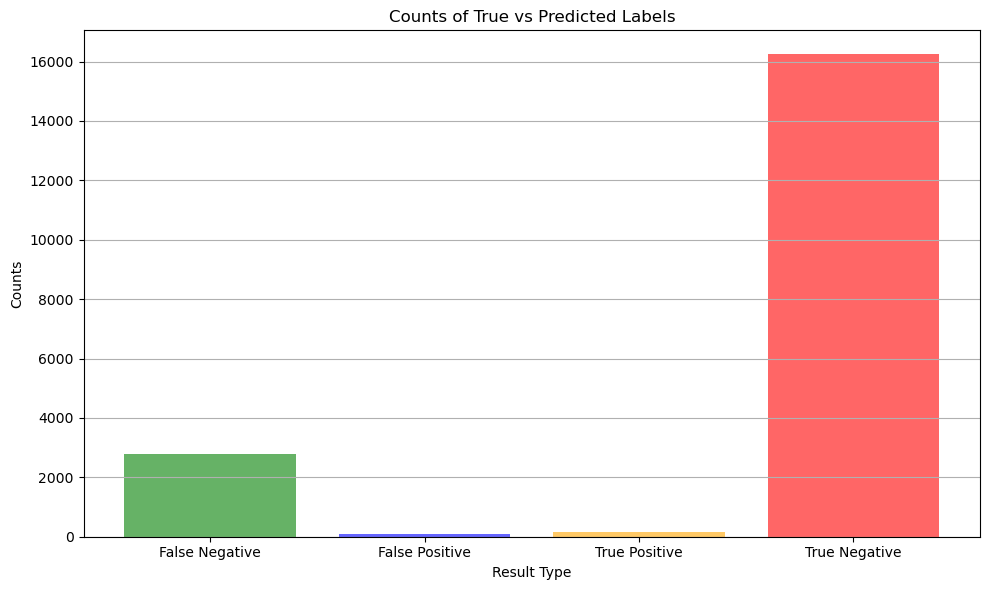

           Result  count
0  False Negative   2799
1  False Positive     89
2   True Positive    173
3   True Negative  16239


In [12]:
summary_pd = plot_results(test_predictions)
print(summary_pd)

We notice that a lot of false negatives have been invoked. The reason for that may be because the dataset is skewed, as it has far more rows with y = 0 than y = 1. Thus, we ran the same experiment again with a 50/50 split. 

In [13]:
from pyspark.sql.functions import col

df_y_1 = df.filter(col("y") == 1)
df_y_0 = df.filter(col("y") == 0)

In [14]:
num_samples = min(df_y_1.count(), df_y_0.count())  # Get the minimum count

sampled_y_1 = df_y_1.sample(
    False, num_samples / df_y_1.count(), seed=42
)  # Randomly sample from y=1
sampled_y_0 = df_y_0.sample(
    False, num_samples / df_y_0.count(), seed=42
)  # Randomly sample from y=0

# Step 3: Union the sampled DataFrames
new_df = sampled_y_1.union(sampled_y_0)

# Show the result
new_df.show()

+-------+--------+--------+-------+------+--------+--------+--------+--------+-------+--------+--------+--------+-----+--------+--------+--------+--------+--------+---+
|GENHLTH|_AGEG5YR|_RFHYPE6|EMPLOY1|_MICHD|_DRDXAR2|_HCVU653|_RFCHOL3|METVL12_|ALCDAY4|_BMI5CAT|DIFFWALK|_TOTINDA|EDUCA|_INCOMG1|CHCKDNY2|FALL12MN|SMOKE100|CVDINFR4|  y|
+-------+--------+--------+-------+------+--------+--------+--------+--------+-------+--------+--------+--------+-----+--------+--------+--------+--------+--------+---+
|    3.0|     7.0|     2.0|    1.0|   2.0|     2.0|     1.0|     2.0|   103.0|  888.0|     4.0|     1.0|     1.0|  4.0|     2.0|     2.0|    88.0|     1.0|     2.0|  1|
|    4.0|     6.0|     1.0|    8.0|   2.0|     1.0|     1.0|     1.0|   104.0|  888.0|     4.0|     1.0|     1.0|  5.0|     1.0|     2.0|     1.0|     1.0|     2.0|  1|
|    4.0|     7.0|     1.0|    5.0|   2.0|     1.0|     1.0|     2.0|     2.0|  201.0|     4.0|     1.0|     2.0|  4.0|     2.0|     2.0|    88.0|     2.0|

In [15]:
df_filled = df.fillna(0)
train_df, test_df = new_df.randomSplit([0.8, 0.2], seed=1)
# Show the counts of each split
print(f"Training set count: {train_df.count()}")
print(f"Test set count: {test_df.count()}")

Training set count: 23578
Test set count: 5781


In [16]:
test_predictions = train(train_df, test_df)

Root Mean Squared Error (RMSE) on test data: 0.42490137937710654
Best Regularization Parameter: 0.01
Best Elastic Net Parameter: 0.1
Coefficients: [0.09589099951882411,0.023123823013819867,0.1570967598632327,0.0,-0.06908907773641496,0.004580003962325201,-0.05513838330790205,0.14028833359230564,0.0,0.00010835118715181695,0.09297524793882364,-0.009793422055826626,0.04013156169426397,-0.008840525578646691,-0.005436187090068259,-0.030988623787825312,0.0,0.0,-0.008767091346115018,0.0,0.0,-0.01576121158542399,-0.006299859753926132,0.007278226077680764,-0.010308193933269559,-0.0111695677809977,0.0030164014463322443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [17]:
accuracy, precision = get_accuracy_precision(test_predictions)

print(f"Accuracy on test data: {accuracy}")
print(f"Precision on test data: {precision}")

Accuracy on test data: 0.728247708008995
Precision on test data: 0.7284401333276622


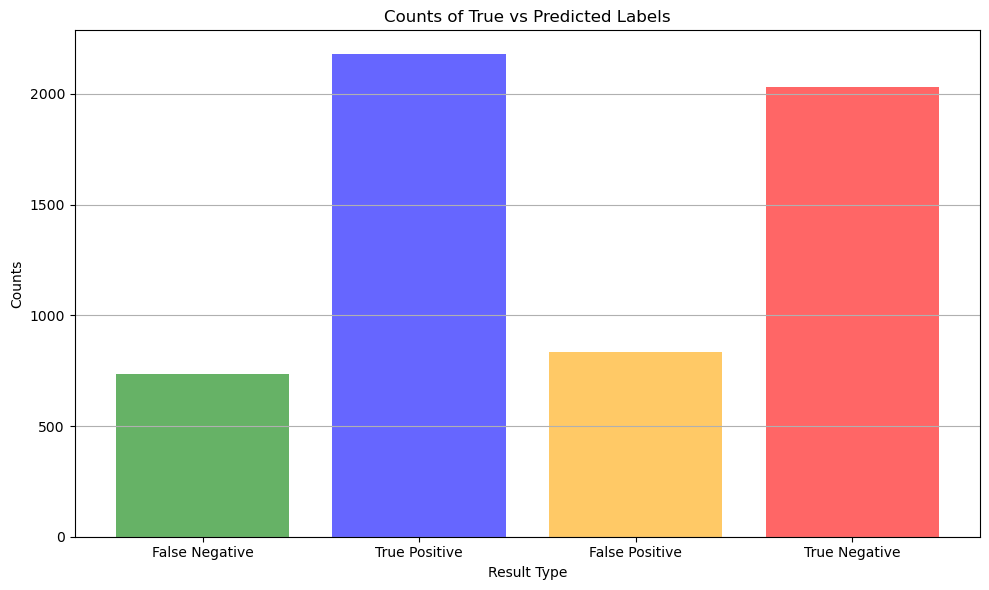

           Result  count
0  False Negative    736
1   True Positive   2178
2  False Positive    835
3   True Negative   2032


In [18]:
summary_df = plot_results(test_predictions)
print(summary_df)